In [1]:
%matplotlib notebook
import numpy as np
import re
import pandas as pd
import orbipy as op
import matplotlib.pyplot as plt
import pickle

In [18]:
import sympy as sp

In [2]:
import dill

In [3]:
model = op.crtbp3_model()
precise_model = op.crtbp3_model()
precise_model.integrator.set_params(max_step=np.pi/180)
stm_model = op.crtbp3_model(stm=True)
plotter = op.plotter.from_model(model, length_units='km', velocity_units='m/s')
scaler = plotter.scaler

In [4]:
class CT:
    def __init__(self, model):
        self.c2 = self.c(2)
        self.mu = model.mu
        self.g = 1.-model.mu - model.L1
        self.w1 = sp.sqrt((self.c2 - 2 - sp.sqrt(9*self.c2**2 - 8*self.c2))/(-2))
        self.w2 = sp.sqrt(self.c2)
        self.l1 = sp.sqrt((self.c2 - 2 + sp.sqrt(9*self.c2**2 - 8*self.c2))/2)
        self.s1 = sp.sqrt(2*self.l1*((4 + 3*self.c2)*self.l1**2 + 4 + 5*self.c2 - 6*self.c2**2))
        self.s2 = sp.sqrt(self.w1*((4 + 3*self.c2)*self.w1**2 - 4 - 5*self.c2 + 6*self.c2**2))
    
    def c(self, n):
        g = sp.Symbol('g')
        mu = sp.Symbol('mu')
        return (mu+((-1)**n)*((1 - mu)*g**(n + 1))/((1 - g)**(n + 1)))/g**3

    def h(self, n):
        if n<=2:
            raise RuntimeError('n must be > 2')
        x,y,z = sp.symbols('x y z')
        sq = sp.sqrt(x**2+y**2+z**2)
        return -1*self.c(n)*sq**n*sp.together(sp.legendre(n, x/sq))
    
    def R(self):
        return sp.Matrix([[2*self.l1/self.s1,0,0,-2*self.l1/self.s1, 2*self.w1/self.s2,0],
                      [(self.l1**2-2*self.c2-1)/self.s1,(-self.w1**2-2*self.c2-1)/self.s2,0,(self.l1**2-2*self.c2-1)/self.s1,0,0],
                      [0,0,1/sp.sqrt(self.w2),0,0,0],
                      [(self.l1**2+2*self.c2+1)/self.s1,(-self.w1**2+2*self.c2+1)/self.s2,0,(self.l1**2+2*self.c2+1)/self.s1,0,0],
                      [(self.l1**3+(1-2*self.c2)*self.l1)/self.s1,0,0,(-self.l1**3-(1-2*self.c2)*self.l1)/self.s1,(-self.w1**3+(1-2*self.c2)*self.w1)/self.s2,0],
                      [0,0,0,0,0,sp.sqrt(self.w2)]]).subs({'g': ct.g, 'mu':ct.mu}).evalf()
    
    def symp_change(self):
        x,y,z,px,py,pz = sp.symbols('x1 y1 z1 px1 py1 pz1')
        mat = sp.Matrix([x,y,z,px,py,pz])
        return self.R()*mat
    
    def h_symp(self, n):
        x, y,z, px, py, pz = sp.symbols('x y z px py pz')
        change = self.symp_change()
        h = self.h(n)
        h = h.subs({'x': change[0], 'y': change[1], 'z': change[2]})
        h = h.subs({'x1': x, 'y1': y, 'z1': z, 'px1': px, 'py1': py, 'pz1': pz})
        h = h.subs({'g': ct.g, 'mu':ct.mu}).expand().evalf()
        return h
    
    def h_complex(self, n):
        y1,z1,py1,pz1 = sp.symbols('y1 z1 py1 pz1')
        y,z,py,pz = sp.symbols('y z py pz')
        sq2 = math.sqrt(2)
        y_change = (y1 + sp.I*py1)/sq2
        z_change = (z1 + sp.I*pz1)/sq2
        py_change = (py1 + sp.I*y1)/sq2
        pz_change = (pz1 + sp.I*z1)/sq2
        if n == 2:
            h = self.h2_symp()
        elif n>2:
            h = self.h_symp(n)
        else:
            raise RuntimeError('unsupported n')
        h = h.subs({'y': y_change, 'z': z_change, 'py': py_change, 'pz': pz_change}).expand()
        h = h.subs({'y1': y, 'z1': z, 'py1': py, 'pz1': pz})
        return h #self.chop(h)
    
    def gen_func(self, h_comp):
        x, y,z,px,py,pz = sp.symbols('x y z px py pz')
        n1 = self.l1.subs({'g': ct.g, 'mu':ct.mu}).evalf()
        n2 = sp.I*self.w1.subs({'g': ct.g, 'mu':ct.mu}).evalf()
        n3 = sp.I*self.w2.subs({'g': ct.g, 'mu':ct.mu}).evalf()
        pol = sp.Poly(h_comp, x,y,z,px,py,pz)
        mons = pol.monoms()
        gen = 0
        for mon in mons:
            a1 = (mon[3]-mon[0])
            a2 = (mon[4]-mon[1])
            a3 = (mon[5]-mon[2])
            if not (a1==0 and a2==0 and a3==0):
                denominator = a1*n1 + a2*n2 + a3*n3
                sym_part = x**mon[0]*y**mon[1]*z**mon[2]*px**mon[3]*py**mon[4]*pz**mon[5]
                coef = -1*pol.coeff_monomial(mon)
                gen += coef*sym_part/denominator
        return gen.expand()
    
    def pbracket(self, f, g):
        x, y,z, px, py, pz = sp.symbols('x y z px py pz')
        q = [x ,y ,z]
        p = [px, py, pz]
        res = 0
        for i in range(3):
            res += sp.diff(f, q[i])*sp.diff(g, p[i]) - sp.diff(f, p[i])*sp.diff(g, q[i])
        return res.expand()
    
    def h2(self):
        x, y,z, px, py, pz = sp.symbols('x y z px py pz')
        h = (self.c2*(-2*x**2 + y**2 + z**2) + 2*y*px - 2*x*py + px**2 + py**2 + pz**2)/2
        return h
    
    def h2_symp(self):
        change = self.symp_change()
        h = self.h2().subs({'x': change[0], 'y': change[1], 'z': change[2], 'px': change[3], 'py': change[4], 'pz': change[5]})
        x, y,z, px, py, pz = sp.symbols('x y z px py pz')
        h = h.subs({'x1': x, 'y1': y, 'z1': z, 'px1': px, 'py1': py, 'pz1': pz})
        h = h.subs({'g': ct.g, 'mu':ct.mu}).expand()
        return h #self.chop(h)
    
    def chop(self, h):
        x, y,z,px,py,pz = sp.symbols('x y z px py pz')
        pol = sp.Poly(h, x,y,z,px,py,pz)
        mons = pol.monoms()
        h_new = 0
#         import pdb; pdb.set_trace()
        for mon in mons:
            coef = pol.coeff_monomial(mon)
            coef_chopped = self.chop_coef(coef)
            a, b = coef_chopped.as_real_imag()
            if abs(a)+abs(b) > 0:
                sym_part = x**mon[0]*y**mon[1]*z**mon[2]*px**mon[3]*py**mon[4]*pz**mon[5]
                h_new += coef_chopped*sym_part
        
        return h_new
    
    def chop_coef(self, coef):
        a, b = coef.as_real_imag()
        new_coef = self.chop_num(a) + self.chop_num(b)*sp.I
#         print('Old coef: {}; New coef: {}'.format(coef, new_coef))
        return new_coef

    def chop_num(self, num, tol=1e-14):
        if abs(num) > tol:
            return num
        else:
            return 0
        
    def new_var(self, var, g, n):
        new_var = 0
        prev = 0
        new_var += var
        prev += new_var
        for i in np.arange(1, n+1):
            cur = self.pbracket(prev, g)
            new_var += cur/math.factorial(i)
            prev = cur.copy()
            
        return new_var.expand()#self.realify(new_var)
    
    
    def realify(self, expr):
        y1,z1,py1,pz1 = sp.symbols('y1 z1 py1 pz1')
        y,z,py,pz = sp.symbols('y z py pz')
        sq2 = math.sqrt(2)
        y_change = (y1 - sp.I*py1)/sq2
        z_change = (z1 - sp.I*pz1)/sq2
        py_change = (py1 - sp.I*y1)/sq2
        pz_change = (pz1 - sp.I*z1)/sq2
        
        real_expr = expr.subs({'y': y_change, 'z': z_change, 'py': py_change, 'pz': pz_change})
        real_expr = real_expr.subs({'y1': y, 'z1': z, 'py1': py, 'pz1': pz})
        
        return real_expr.expand()

In [5]:
class Hyperbolic:
    def __init__(self):
        self.c2 = self.calc_c2()
        self.lam = self.calc_lam()
        self.omega = self.calc_omega()
        self.k1 = self.calc_k1()
        self.k2 = self.calc_k2()
        self.k3 = self.calc_k3()
        self.k4 = self.calc_k4()
        
    def p1(self, state):
        (x, y) = state[:2]
        x -= model.L1
        (vx, vy) = state[3:5]
        
        return ((self.k3*self.omega*x-self.k1*vy)/(self.k1*self.k4*self.lam+self.k2*self.k3*self.omega) +\
                (self.k1*self.omega*y+self.k3*vx)/(self.k2*self.k3*self.lam-self.k1*self.k4*self.omega))/2
    
    def p1_table(self, orbit):
        x = orbit['x'].values - model.L1
        vx = orbit['vx'].values
        y = orbit['y'].values
        vy = orbit['vy'].values
        
        return ((self.k3*self.omega*x-self.k1*vy)/(self.k1*self.k4*self.lam+self.k2*self.k3*self.omega) +\
                (self.k1*self.omega*y+self.k3*vx)/(self.k2*self.k3*self.lam-self.k1*self.k4*self.omega))/2
    
    def p2_table(self, orbit):
        x = orbit['x'].values - model.L1
        vx = orbit['vx'].values
        y = orbit['y'].values
        vy = orbit['vy'].values
        
        return ((self.k3*self.omega*x-self.k1*vy)/(self.k1*self.k4*self.lam+self.k2*self.k3*self.omega) -\
                (self.k1*self.omega*y+self.k3*vx)/(self.k2*self.k3*self.lam-self.k1*self.k4*self.omega))/2
    
    def p2(self, state):
        (x, y) = state[:2]
        x -= model.L1
        (vx, vy) = state[3:5]
        
        return ((self.k3*self.omega*x-self.k1*vy)/(self.k1*self.k4*self.lam+self.k2*self.k3*self.omega) -\
                (self.k1*self.omega*y+self.k3*vx)/(self.k2*self.k3*self.lam-self.k1*self.k4*self.omega))/2
    
    def calc_vy(self, state):
        (x, y) = state[:2]
        x -= model.L1
        (vx, vy) = state[3:5]
        
        return (self.k3*self.omega*x+(self.k1*self.k4*self.lam+self.k2*self.k3*self.omega)*(self.k1*self.omega*y+self.k3*vx)/(self.k2*self.k3*self.lam-self.k1*self.k4*self.omega))/self.k1
        
    def calc_c2(self):
        r1 = np.abs(model.L1+model.mu)
        r2 = np.abs(model.L1+model.mu-1)
        
        return (1.-model.mu)/r1**3+model.mu/r2**3
    
    def calc_lam(self):
        return np.sqrt((self.c2-2+np.sqrt(9*self.c2**2-8*self.c2))/2)
    
    def calc_omega(self):
        return np.sqrt((-1.*self.c2+2+np.sqrt(9*self.c2**2-8*self.c2))/2)
        
    def calc_k1(self):
        return -2/(self.c2+3+self.lam**2)
    
    def calc_k2(self):
        return -2/(2*self.c2+1-self.lam**2)
    
    def calc_k3(self):
        return (self.omega*(self.c2-1+self.lam**2))/((self.c2-1)*(self.c2+3+self.lam**2))
    
    def calc_k4(self):
        return (self.lam*(-2*self.c2+3+self.lam**2))/((self.c2-1)*(-2*self.c2-1+self.lam**2))

In [38]:
class CanonicTransform:
    def __init__(self, data_path, model, symp_mat_inverse):
        self.mu = model.mu
        self.gamma = 1.-model.mu-model.L1
        self.formula = dill.load(open(data_path, "rb"))
        self.symp_mat_inverse = symp_mat_inverse
        
    def symp_change(self, states):
        return (self.symp_mat_inverse @ states.transpose()).transpose()
        
    def apply_shift_scale(self, states):
        # 0-x 1-y 2-z 3-vx 4-vy 5-vz
        shift = (self.gamma+self.mu-1)/self.gamma
        states_new = states/self.gamma
        states_new[:,3] -= states[:,1]/self.gamma
        states_new[:,4] += states[:,0]/self.gamma
        states_new[:,0] += shift
        states_new[:,4] += shift
        return states_new
    
    def apply(self, states):
        arr = self.apply_shift_scale(states)
        arr = self.symp_change(arr)
        result = self.formula(arr[:,0],arr[:,1],arr[:,2],arr[:,3],arr[:,4],arr[:,5])
        return result

In [84]:
x0 = model.L1 + scaler(100, 'km-nd')
z0 = scaler(100, 'km-nd')
s0 = model.get_zero_state()
s0[0] = x0
s0[2] = z0

In [85]:
EL1_dist = 1.-model.mu - model.L1
left = op.eventXleft = op.eventX(model.L1-EL1_dist)
right = op.eventX(1.-model.mu)

In [86]:
corr = op.border_correction(model, op.y_direction(), left, right)

In [87]:
sk = op.simple_station_keeping(precise_model,corr, corr)

In [88]:
orb = sk.prop(0.0, s0, 30)

Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 


## Исходня исследуемая орбита

<IPython.core.display.Javascript object>


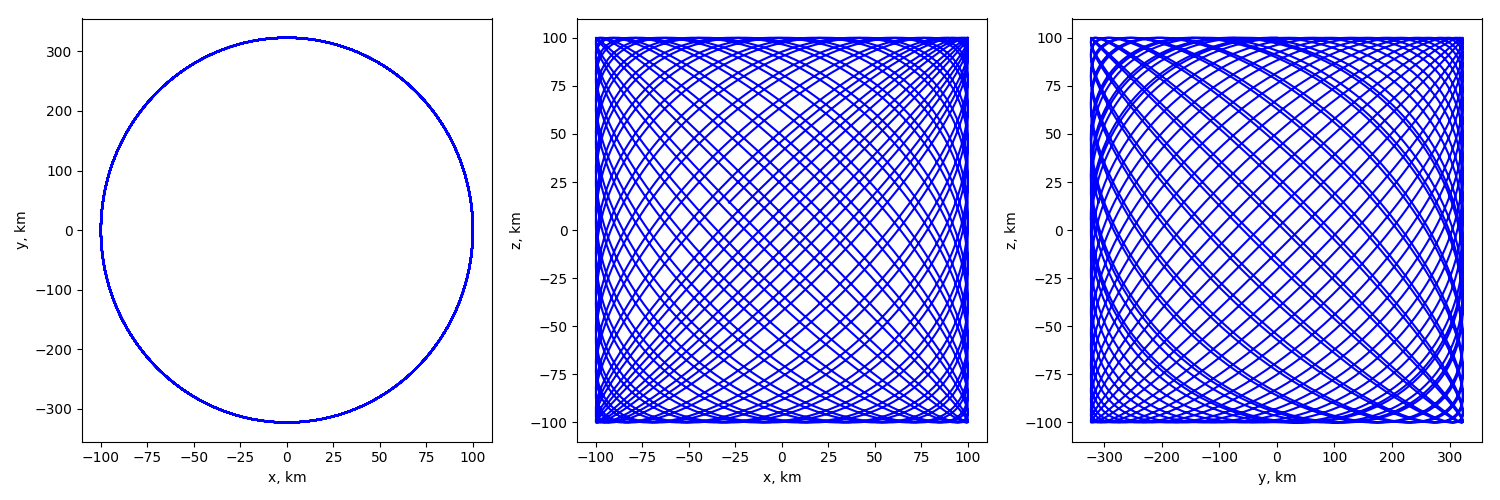

In [89]:
ax = plotter.plot_proj(orb, centers={'x': model.L1, 'y': 0.0, 'z': 0.0})
#plotter.plot_proj(ax=ax, plottables = [plotter.m], marker = 'o')

In [229]:
class Experiment:
    def __init__(self, model, precise_model, dx, dz):
        self.model = model
        self.precise_model = precise_model
        self.s0 = self.model.get_zero_state()
        self.s0[0] = self.model.L1 + dx
        self.s0[2] = dz
        self.EL1_dist = 1.-self.model.mu - self.model.L1
        self.left = op.eventX(self.model.L1-self.EL1_dist)
        self.right = op.eventX(1.-self.model.mu)
        self.corr = op.border_correction(self.model, op.y_direction(), self.left, self.right)
        self.sk = op.simple_station_keeping(self.precise_model, corr, corr)
        self.plotter = op.plotter.from_model(self.model, length_units='km', velocity_units='m/s')
        self.ct = CT(self.model)
        self.symp_mat_inverse = np.linalg.inv(np.array(self.ct.R()).astype(np.float64))
        self.ct_x3 = CanonicTransform('./x32.bin', self.model, self.symp_mat_inverse)
        self.ct_x4 = CanonicTransform('./x42.bin', self.model, self.symp_mat_inverse)
        self.ct_x5 = CanonicTransform('./x5.bin', self.model, self.symp_mat_inverse)
        
        
    def planes_orbit(self, plot=True):
        self.orb = self.sk.prop(0.0, self.s0, 30)
        if plot:
            self.plotter.plot_proj(self.orb, centers={'x': model.L1}, fsize=(3.2,3.2))
        return orb
    
    def x_symp_change(self,plot=True):
        orb_states = self.orb.drop('t', axis=1).to_numpy()
        temp1 = self.ct_x3.apply_shift_scale(orb_states)
        temp2 = self.ct_x3.symp_change(temp1)
        
        if plot:
            plt.plot(self.orb['t'], temp2[:,0])
            plt.title('x после симплектического преобразования')
            plt.xlabel('t')
            plt.ylabel('x')
        return temp2
    
    def x3_nullify(self, plot=True):
        orb_states = self.orb.drop('t', axis=1).to_numpy()
        orb_x3 = self.ct_x3.apply(orb_states)
        
        if plot:
            plt.plot(self.orb['t'], orb_x3)
            plt.title('x после зануления мономов степени 3')
            plt.xlabel('t')
            plt.ylabel('x')
        
        return orb_x3    
    
    def x4_nullify(self, plot=True):
        orb_states = self.orb.drop('t', axis=1).to_numpy()
        orb_x4 = self.ct_x4.apply(orb_states)
        
        if plot:
            plt.title('x после зануления мономов степени 4')
            plt.plot(self.orb['t'], orb_x4)
            plt.xlabel('t')
            plt.ylabel('x')
        
        return orb_x4
    
    def x5_nullify(self, plot=True):
        orb_states = self.orb.drop('t', axis=1).to_numpy()
        orb_x5 = self.ct_x5.apply(orb_states)
        
        if plot:
            plt.plot(self.orb['t'], orb_x5)
            plt.title('x после зануления мономов степени 5')
            plt.xlabel('t')
            plt.ylabel('x')
        
        return orb_x5

# dx=1 км dz=1 км

In [230]:
exp = Experiment(model, precise_model, 1/model.R, 1/model.R)

Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 


<IPython.core.display.Javascript object>


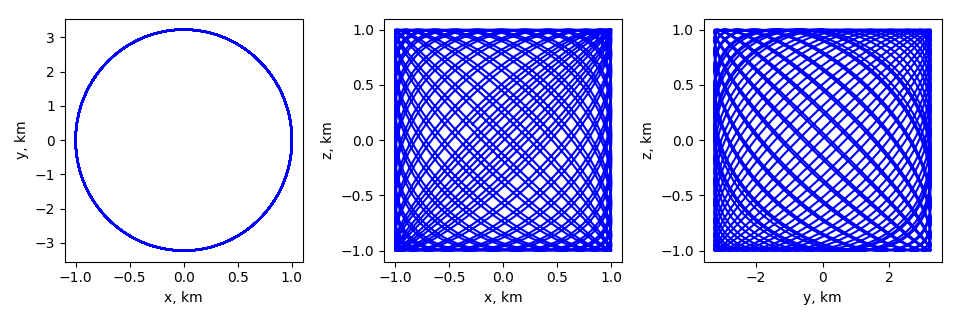

In [231]:
_=exp.planes_orbit()

<IPython.core.display.Javascript object>


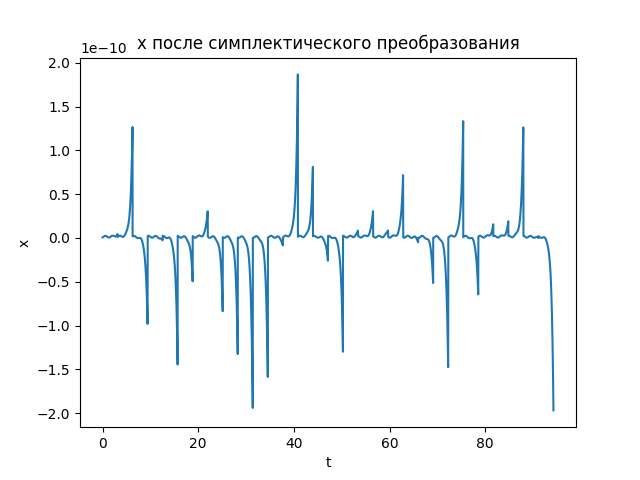

In [232]:
_=exp.x_symp_change()

<IPython.core.display.Javascript object>


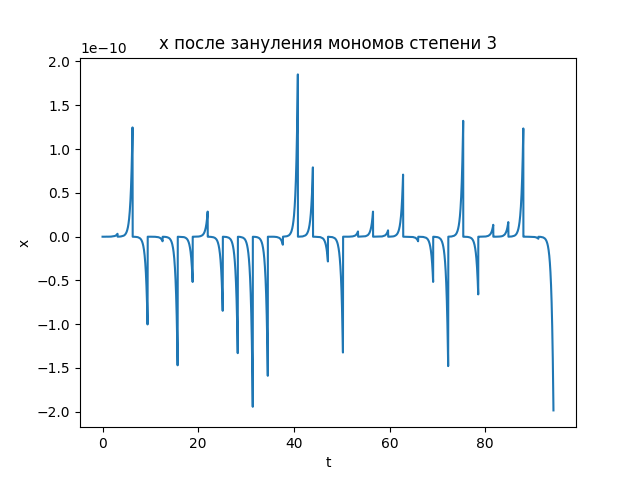

In [233]:
t3=exp.x3_nullify()

<IPython.core.display.Javascript object>


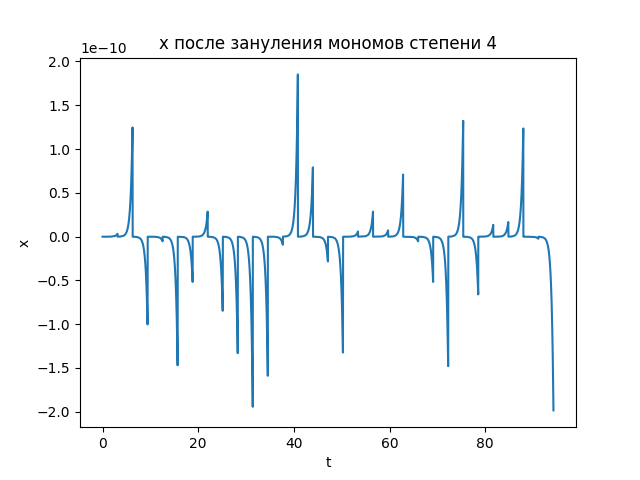

In [234]:
t4=exp.x4_nullify()

In [235]:
(t4-t3).max()

5.991875878763815e-18

<IPython.core.display.Javascript object>


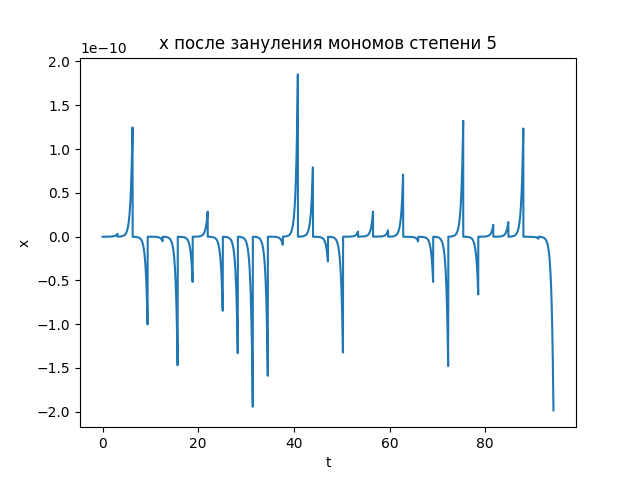

In [236]:
_=exp.x5_nullify()

# dx = 10 км dz = 10 км

In [237]:
exp = Experiment(model, precise_model, 10/model.R, 10/model.R)

Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 


<IPython.core.display.Javascript object>


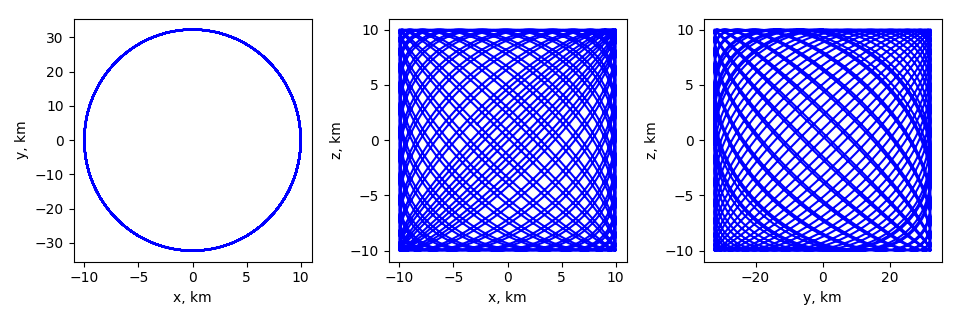

In [240]:
_=exp.planes_orbit()

<IPython.core.display.Javascript object>


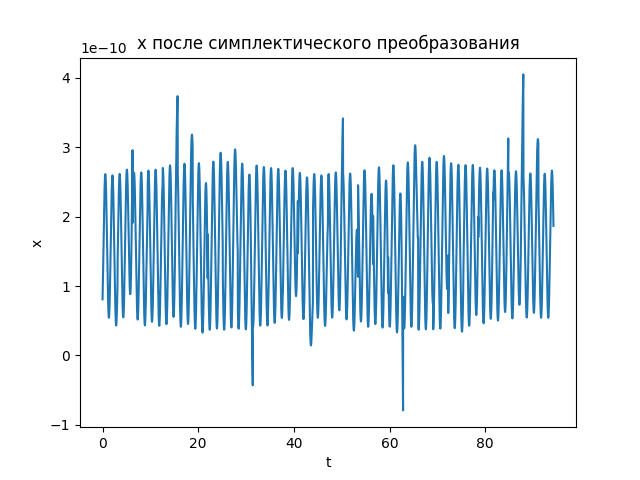

In [241]:
_=exp.x_symp_change()

<IPython.core.display.Javascript object>


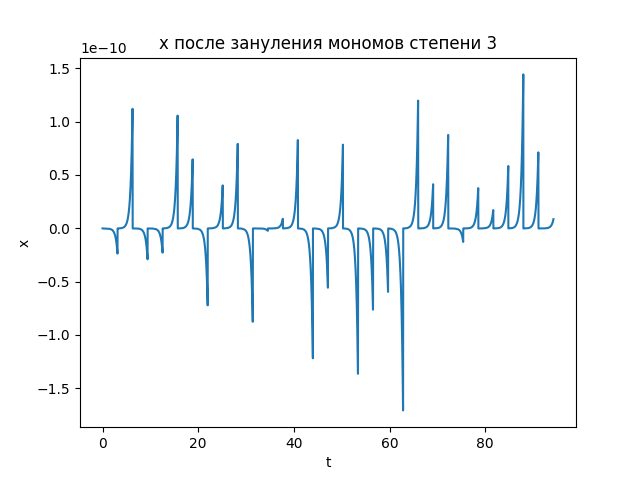

In [242]:
t3=exp.x3_nullify()

<IPython.core.display.Javascript object>


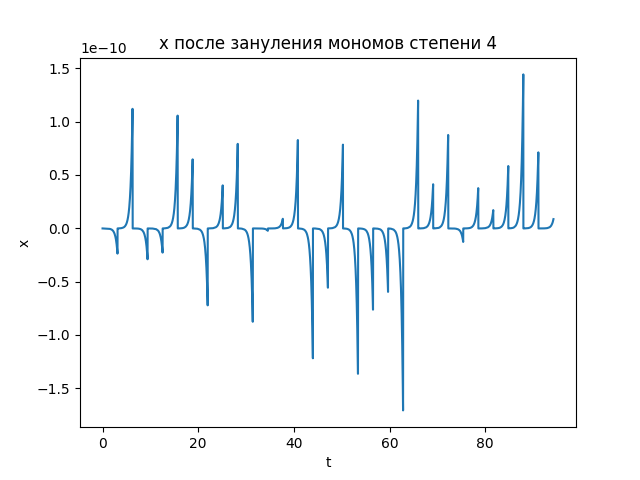

In [243]:
t4=exp.x4_nullify()

In [244]:
(t4-t3).max()

5.987656795189287e-15

<IPython.core.display.Javascript object>


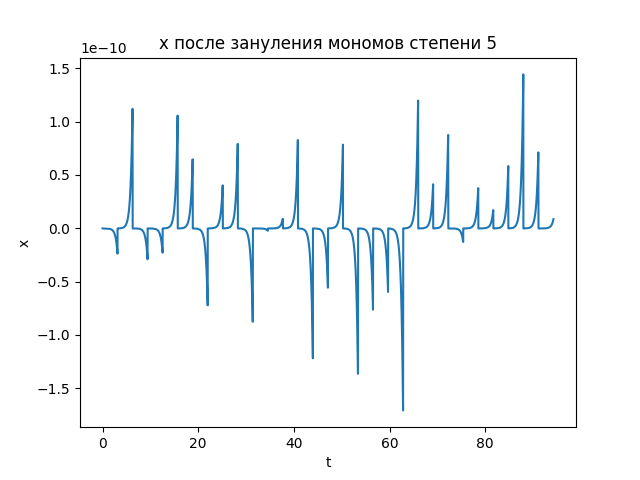

In [166]:
_=exp.x5_nullify()

# dx=50 км dz=50 км

In [245]:
exp = Experiment(model, precise_model, 50/model.R, 50/model.R)

Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 


<IPython.core.display.Javascript object>


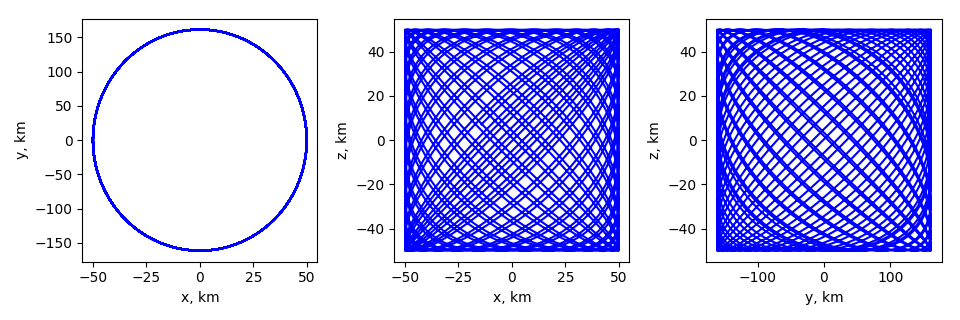

In [247]:
_=exp.planes_orbit()

<IPython.core.display.Javascript object>


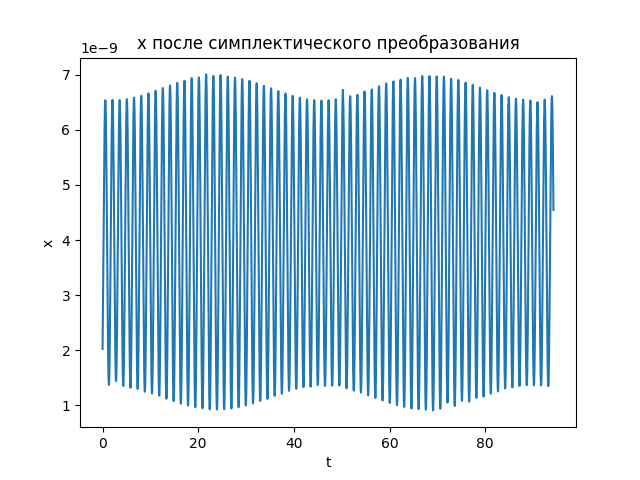

In [248]:
_=exp.x_symp_change()

<IPython.core.display.Javascript object>


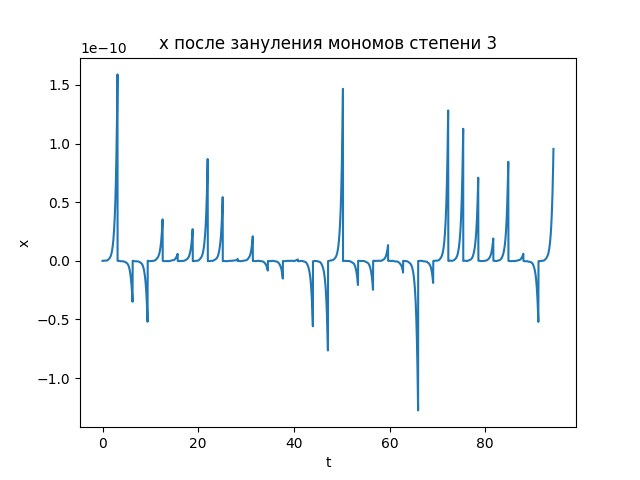

In [251]:
t3=exp.x3_nullify()

<IPython.core.display.Javascript object>


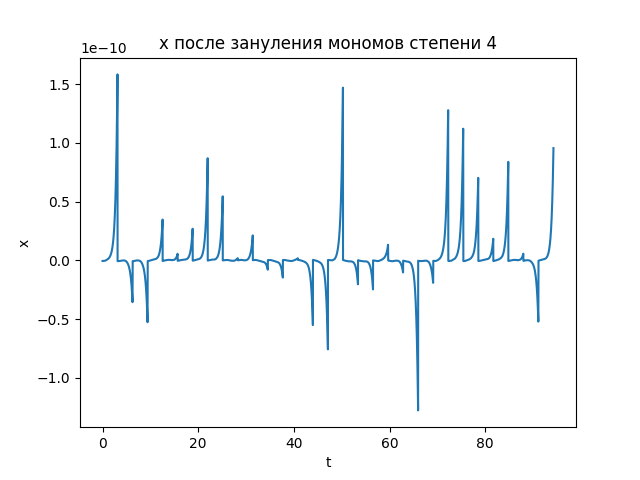

In [252]:
t4=exp.x4_nullify()

In [253]:
(t4-t3).max()

7.483845859241021e-13

<IPython.core.display.Javascript object>


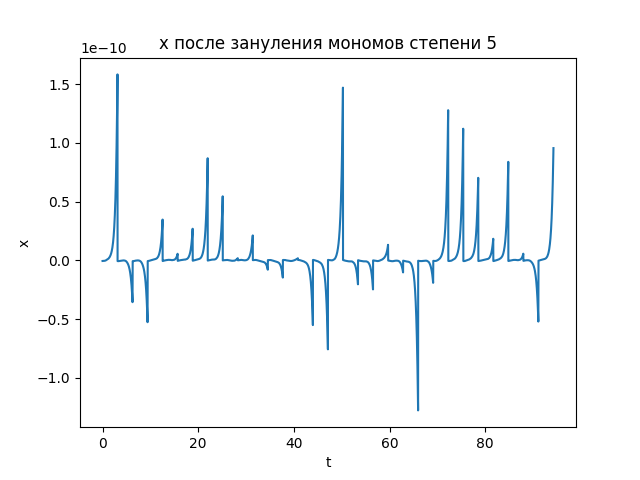

In [173]:
_=exp.x5_nullify()

# dx=100 км dz=100 км

In [254]:
exp = Experiment(model, precise_model, 100/model.R, 100/model.R)

Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 


<IPython.core.display.Javascript object>


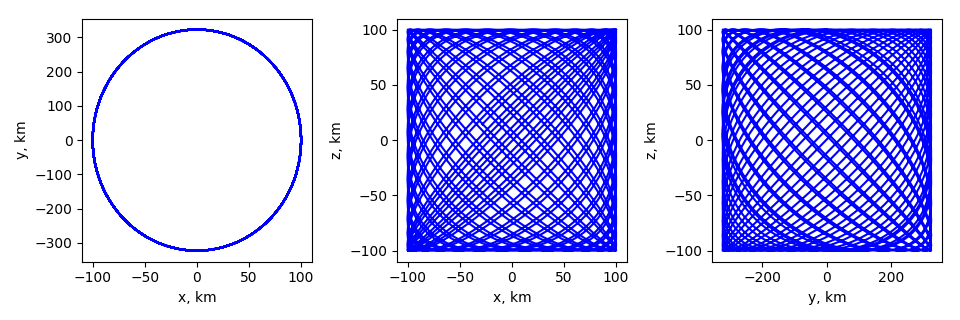

In [255]:
_=exp.planes_orbit()

<IPython.core.display.Javascript object>


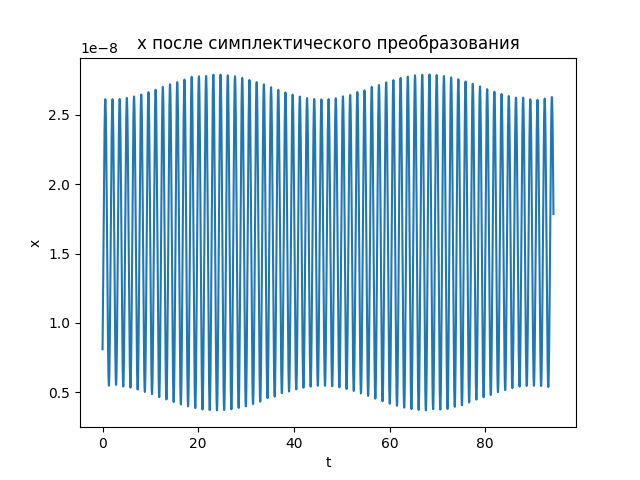

In [256]:
_=exp.x_symp_change()

<IPython.core.display.Javascript object>


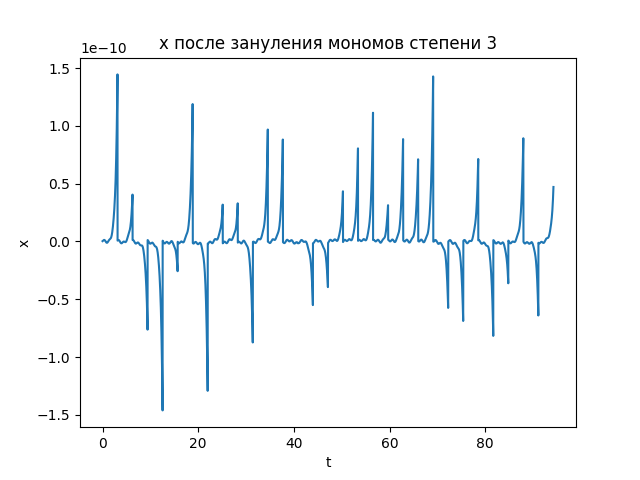

In [259]:
t3=exp.x3_nullify()

<IPython.core.display.Javascript object>


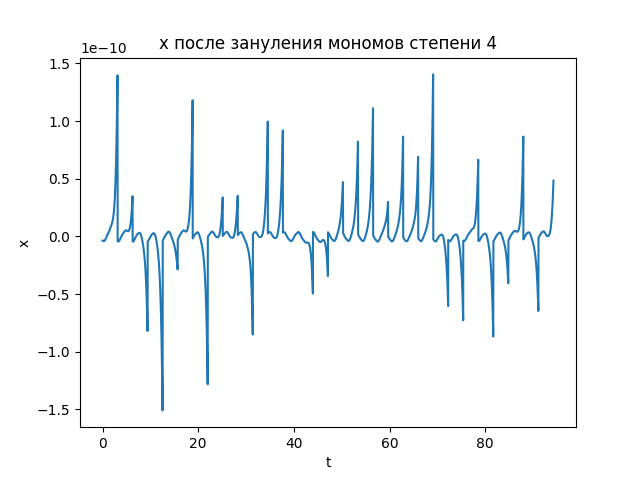

In [260]:
t4=exp.x4_nullify()

In [263]:
(t4-t3).max()

5.98637657110258e-12

<IPython.core.display.Javascript object>


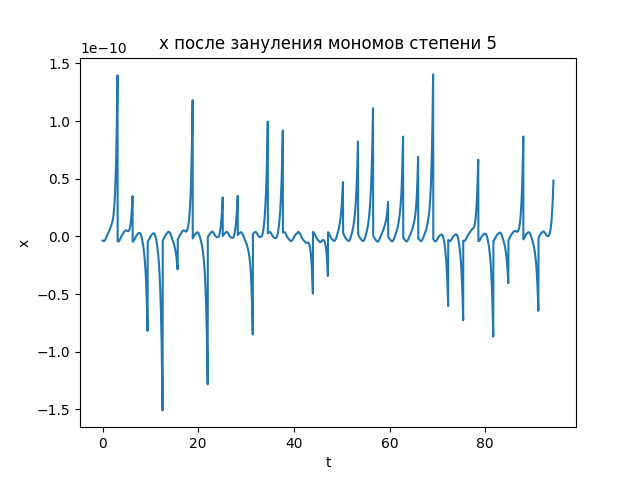

In [261]:
t5=exp.x5_nullify()

In [262]:
(t5-t4).max()

4.125145242649967e-15

# dx=200 км dz=200 км

In [264]:
exp = Experiment(model, precise_model, 200/model.R, 200/model.R)

Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 


<IPython.core.display.Javascript object>


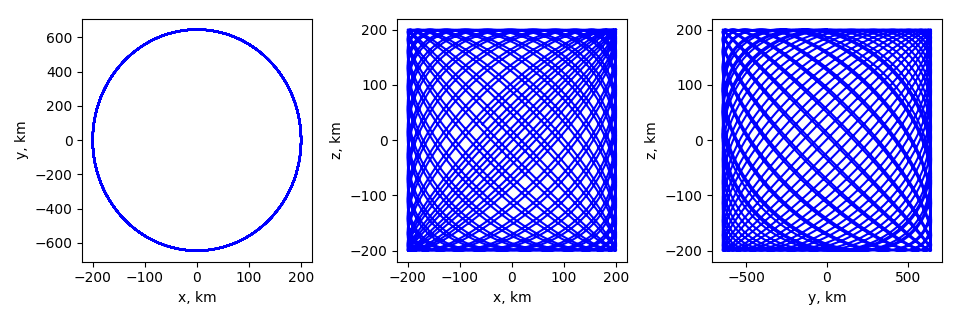

In [265]:
_=exp.planes_orbit()

<IPython.core.display.Javascript object>


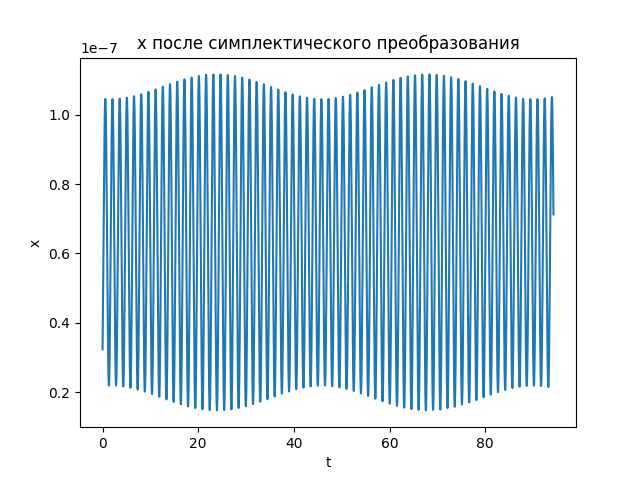

In [266]:
_=exp.x_symp_change()

<IPython.core.display.Javascript object>


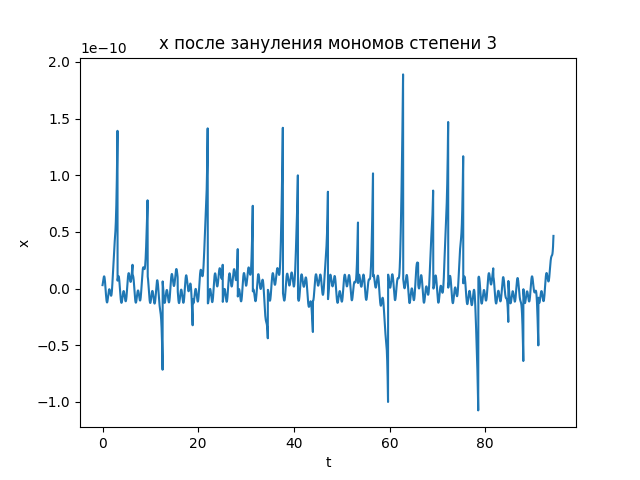

In [267]:
t3=exp.x3_nullify()

<IPython.core.display.Javascript object>


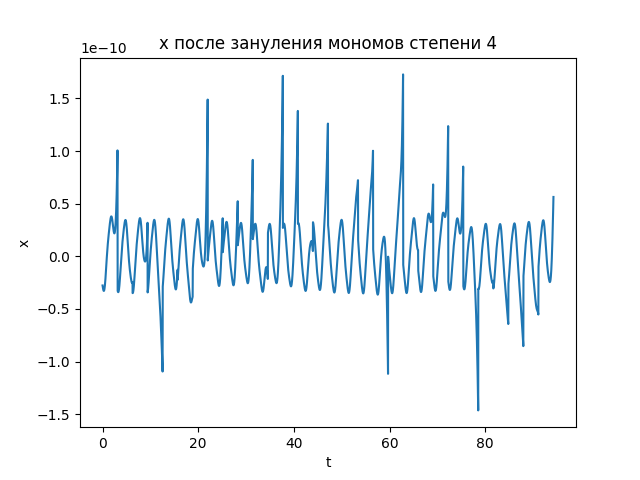

In [268]:
t4=exp.x4_nullify()

<IPython.core.display.Javascript object>


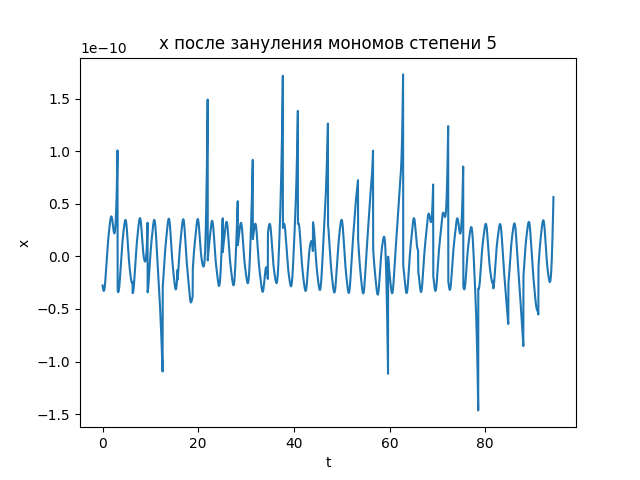

In [269]:
t5=exp.x5_nullify()

# dx=300 км dz=300 км

In [270]:
exp = Experiment(model, precise_model, 300/model.R, 300/model.R)

Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 


<IPython.core.display.Javascript object>


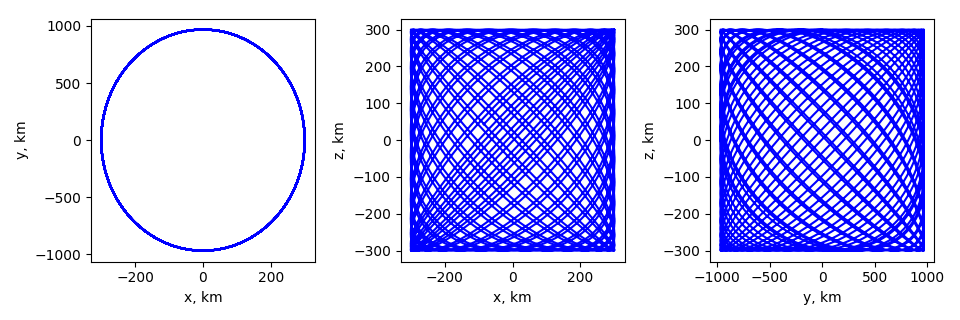

In [271]:
_=exp.planes_orbit()

<IPython.core.display.Javascript object>


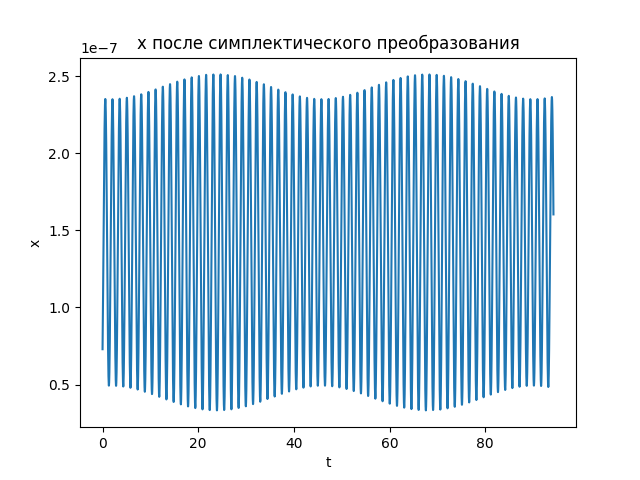

In [272]:
_=exp.x_symp_change()

<IPython.core.display.Javascript object>


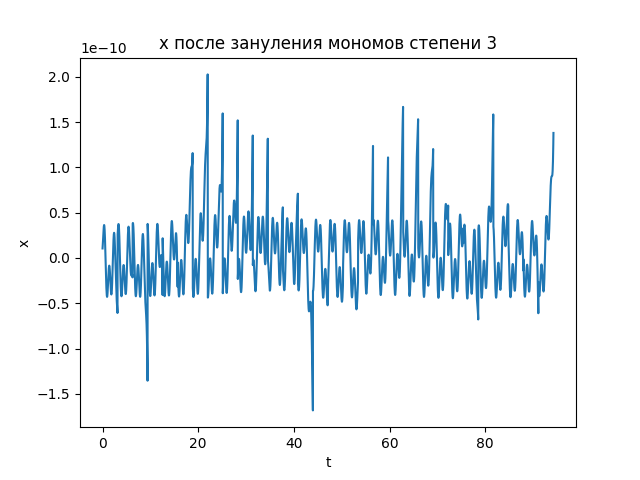

In [273]:
t3=exp.x3_nullify()

<IPython.core.display.Javascript object>


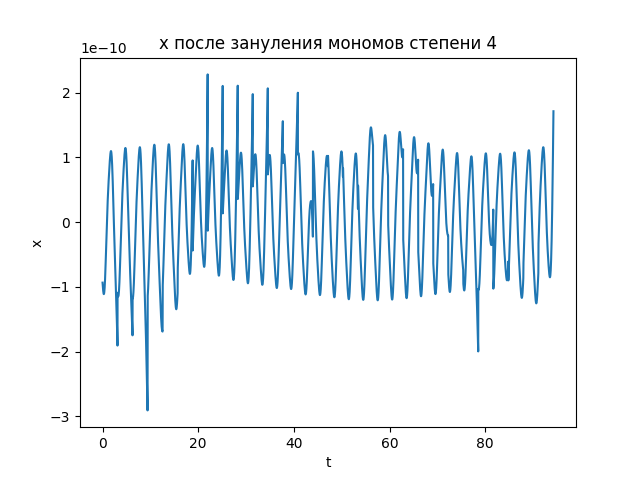

In [274]:
t4=exp.x4_nullify()

In [275]:
(t4-t3).max()

1.6155931598789432e-10

<IPython.core.display.Javascript object>


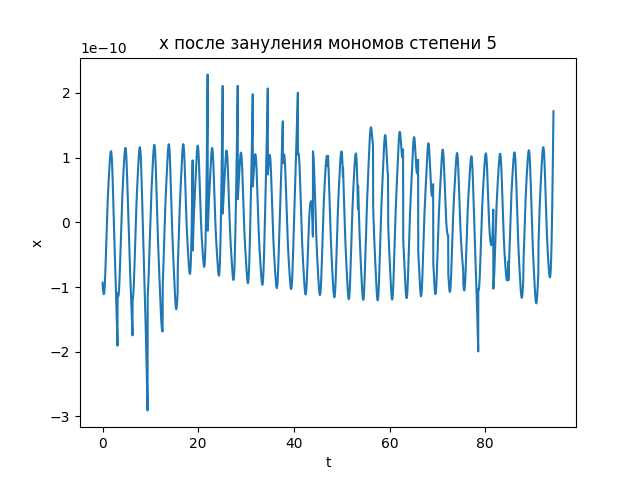

In [276]:
_=exp.x5_nullify()

In [ ]:
# exp = Experiment(model, precise_model, 10/model.R, 10/model.R)
# _=exp.planes_orbit()
# _=exp.x_symp_change()
# _=exp.x3_nullify()
# _=exp.x4_nullify()
# _=exp.x5_nullify()